In [1]:

import os
from os.path import join
import yaml
import pickle
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm
import torch

import ili
from ili.dataloaders import StaticNumpyLoader, SBISimulator
from ili.validation.runner import ValidationRunner 
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


from CASBI.generator.fff.fff_model import FreeFormFlow
from CASBI.utils.create_dataframe import rescale


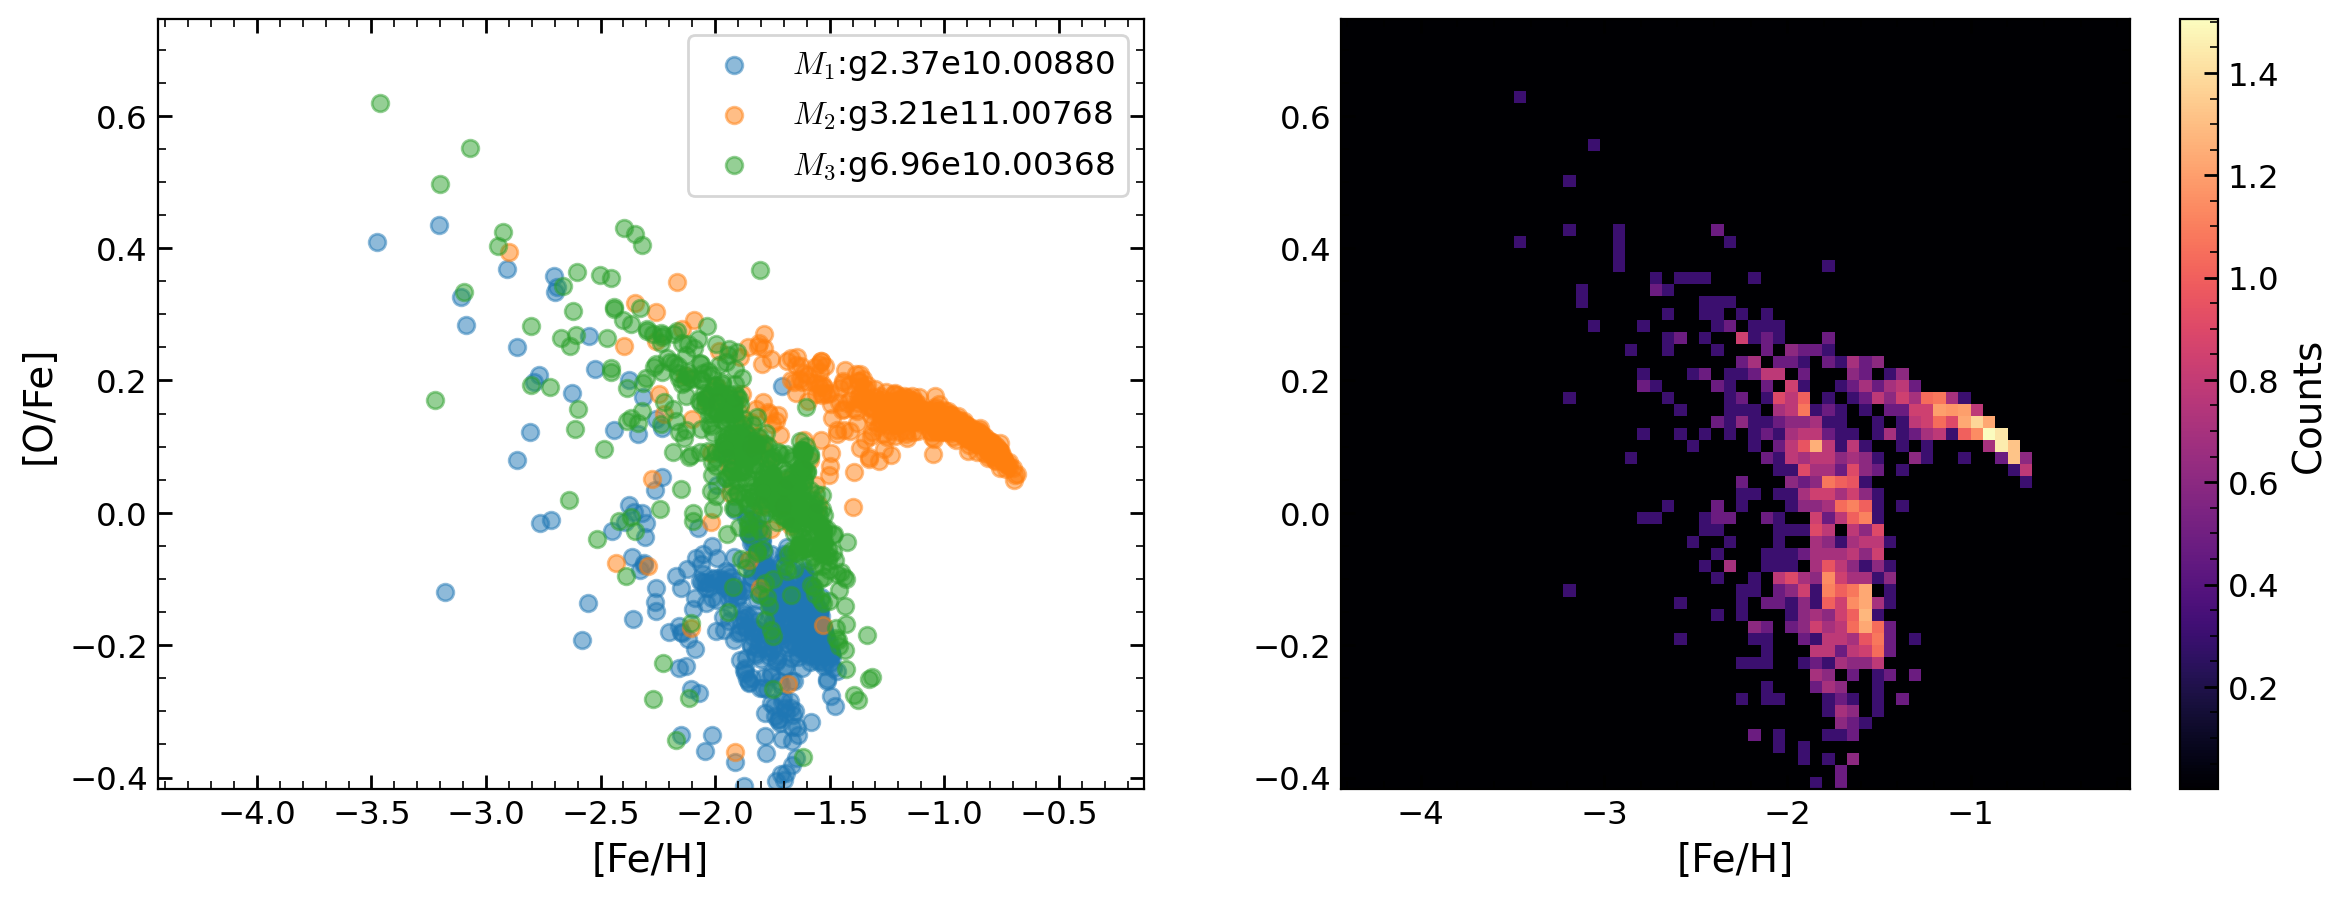

In [2]:
data = pd.read_parquet('../../../../data/dataframe/dataframe.parquet')
data = rescale(data, mean_and_std_path='../../../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameter=True, inverse=True) 
data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])

data_to_plot_halos = pd.read_parquet('./halos_0.parquet')

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(121)
for i, galaxy in enumerate(data_to_plot_halos['Galaxy_name'].unique()):
    observables =  data_to_plot_halos[data_to_plot_halos['Galaxy_name'] == galaxy]
    ax.scatter(observables['feh'], observables['ofe'], label=f'$M_{i+1}$:{galaxy}',alpha=0.5)
    ax.set_xlabel('[Fe/H]')   
    ax.set_ylabel('[O/Fe]')
    ax.set_xlim((min_feh, max_feh))
    ax.set_ylim((min_ofe, max_ofe))
    ax.legend()
ax = fig.add_subplot(122)
im = ax.imshow(np.load('x_0.npy').T, origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='magma')
ax.set_xlabel('[Fe/H]')   
# ax.set_ylabel('[O/Fe]')
cbar = fig.colorbar(im, ax=ax, label='Counts')
cbar.set_label('Counts', size=14)

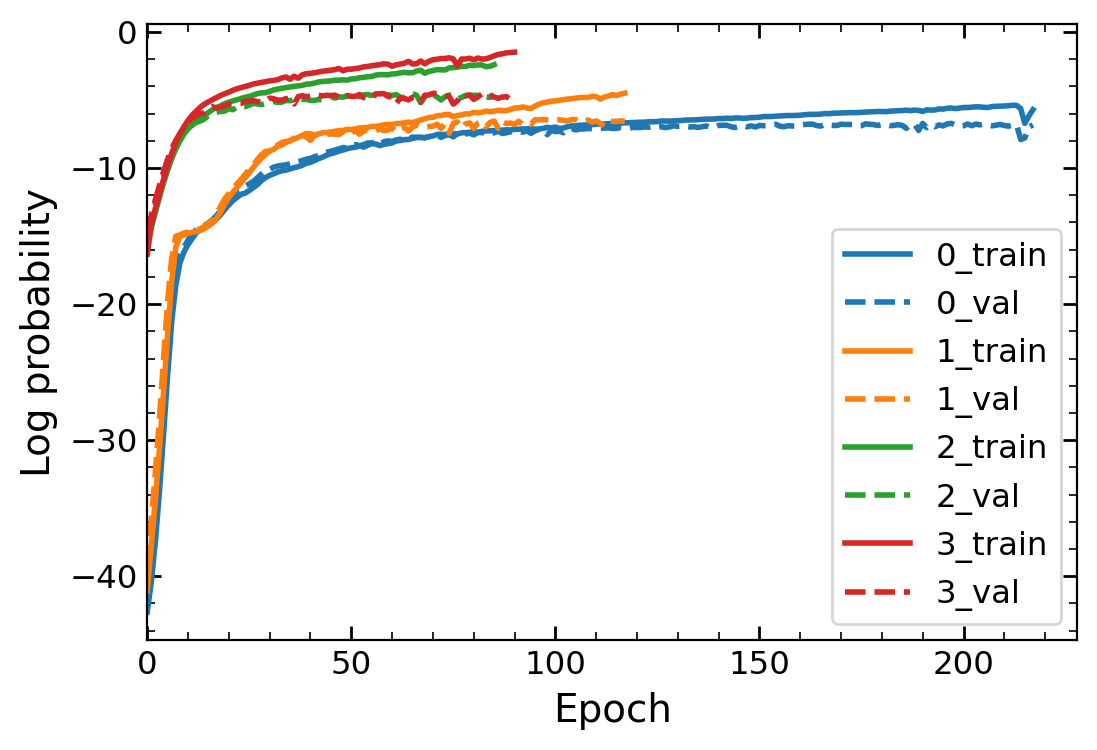

In [3]:
# Open the JSON file
with open('toy_NPE_summary.json', 'r') as f:
    # Load the data from the file
    summaries = json.load(f)
    
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [4]:
labels = [r'\log_{10}($M_{s, 1})\ [M_\odot]$', r'$\log_{10}(M_{s, 2})\ [M_\odot]$', r'$\log_{10}(M_{s, 3})\ [M_\odot]$', r'$\log_{10}(M_{DM, 1})\ [M_\odot]$', r'$\log_{10}(M_{DM, 2})\ [M_\odot]$', r'$\log_{10}(M_{DM, 3})\ [Gyr]$', r'$\tau_{1}\ [Gyr]$', r'$\tau_{2}\ [Gyr]$', r'$\tau_{3}\ [Gyr]$ ']

samples = {}
m = 'NPE'
with open(join('./', 'toy_NPE_posterior.pkl'), 'rb') as f:
    samples[m] = pickle.load(f)
posterio_samples = samples['NPE'].sample((5_000,), x=torch.from_numpy(np.load('./x_0.npy')).to('cuda'))

Drawing 242 posterior samples:   0%|          | 0/242 [00:00<?, ?it/s]

Drawing 333 posterior samples:   0%|          | 0/333 [00:00<?, ?it/s]

Drawing 2132 posterior samples:   0%|          | 0/2132 [00:00<?, ?it/s]

/export/home/vgiusepp/.local/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  outputs, _ = torch.triangular_solve(


Drawing 2293 posterior samples:   0%|          | 0/2293 [00:00<?, ?it/s]

Drawing 237 posterior samples:   0%|          | 0/237 [00:00<?, ?it/s]

Drawing 333 posterior samples:   0%|          | 0/333 [00:00<?, ?it/s]

Drawing 2183 posterior samples:   0%|          | 0/2183 [00:00<?, ?it/s]

Drawing 2247 posterior samples:   0%|          | 0/2247 [00:00<?, ?it/s]

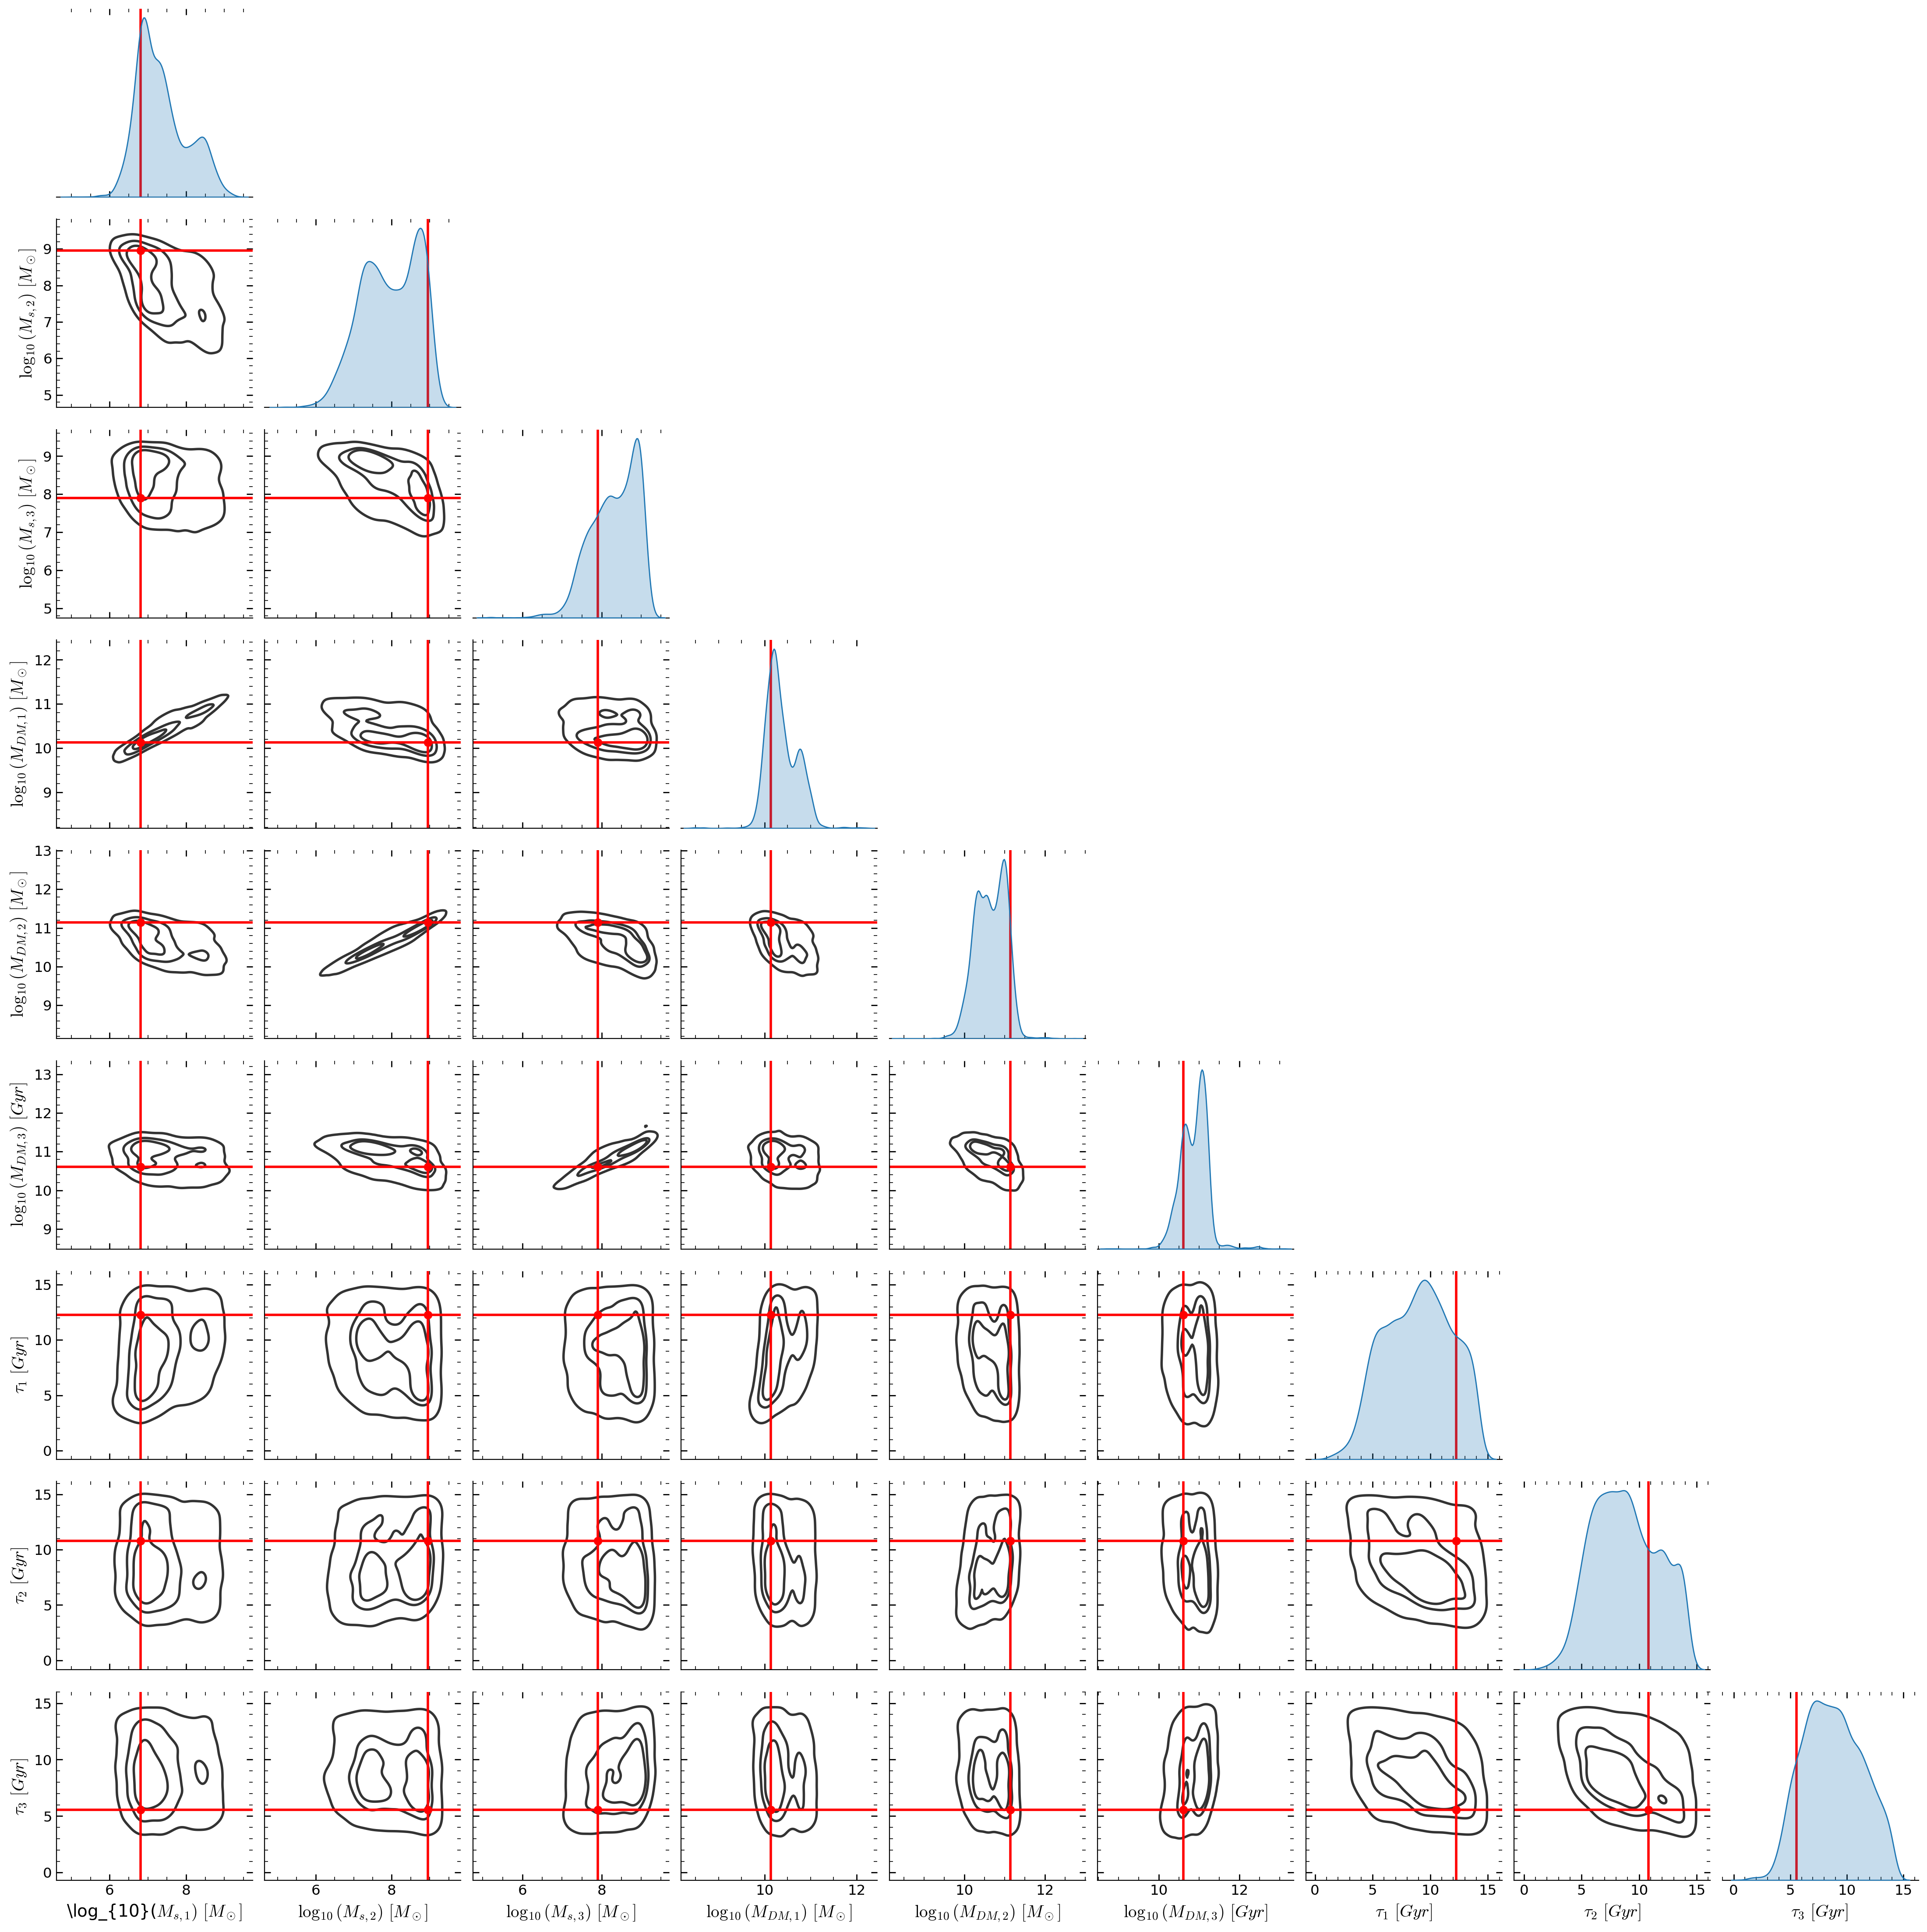

In [5]:
metric = PlotSinglePosterior(
    num_samples=5_000, sample_method='direct', 
    labels = labels,
    out_dir=None
)
fig = metric(
    posterior=samples[m],
    x_obs = torch.from_numpy(np.load('./x_0.npy')), theta_fid=torch.from_numpy(np.load('./theta_0.npy')),
)
fig.savefig('corner_2subhalos.png')

100%|██████████| 100/100 [00:40<00:00,  2.45it/s]
/export/home/vgiusepp/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/export/home/vgiusepp/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


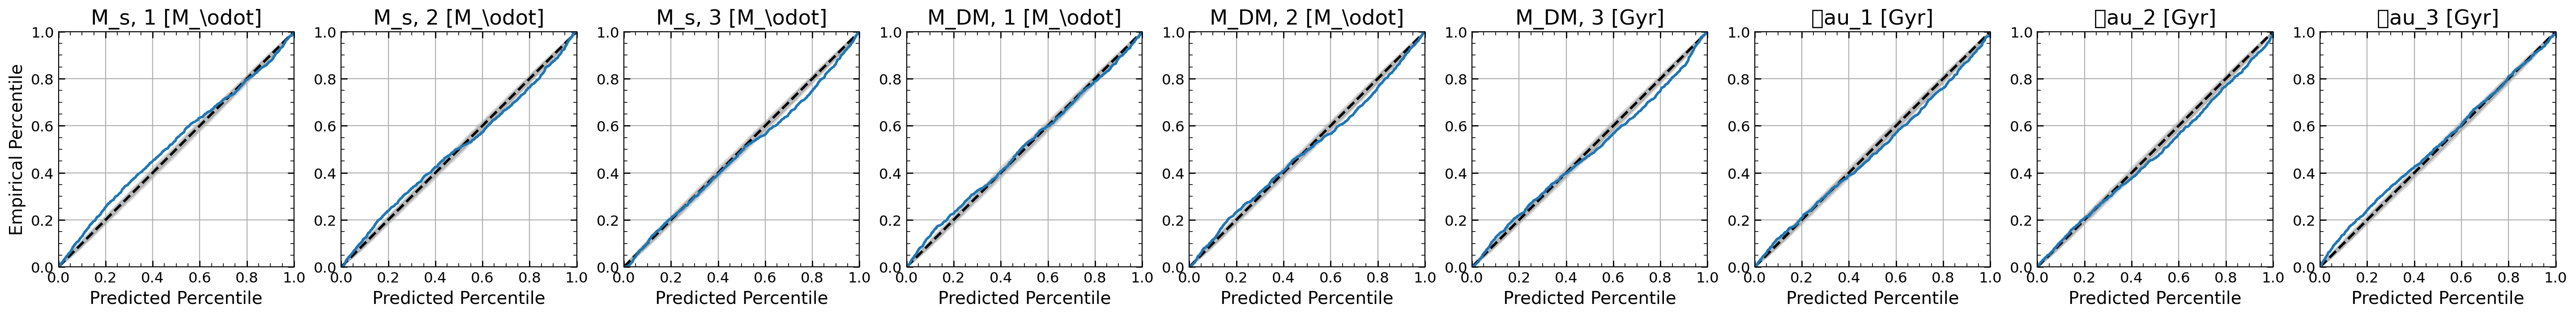

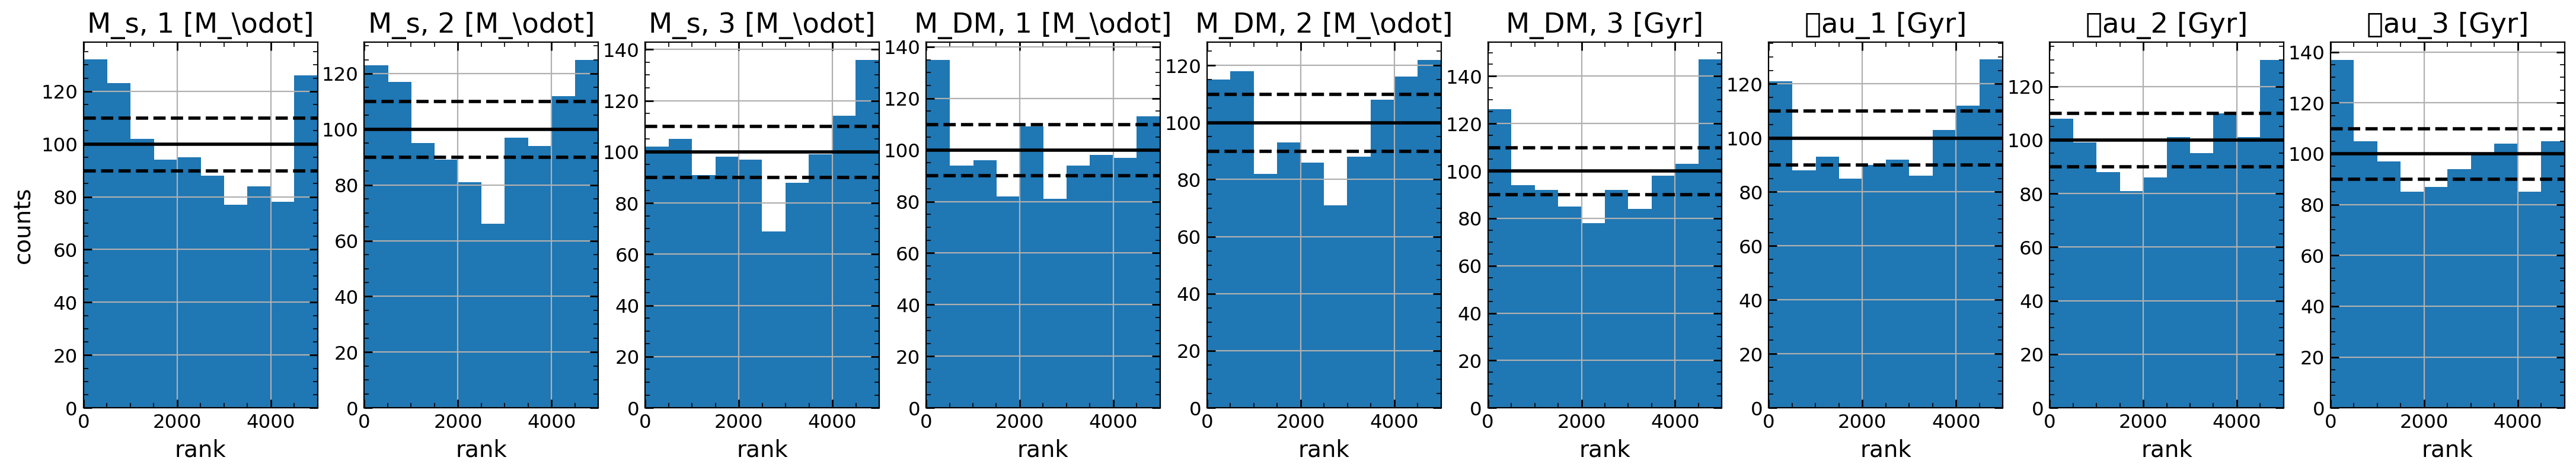

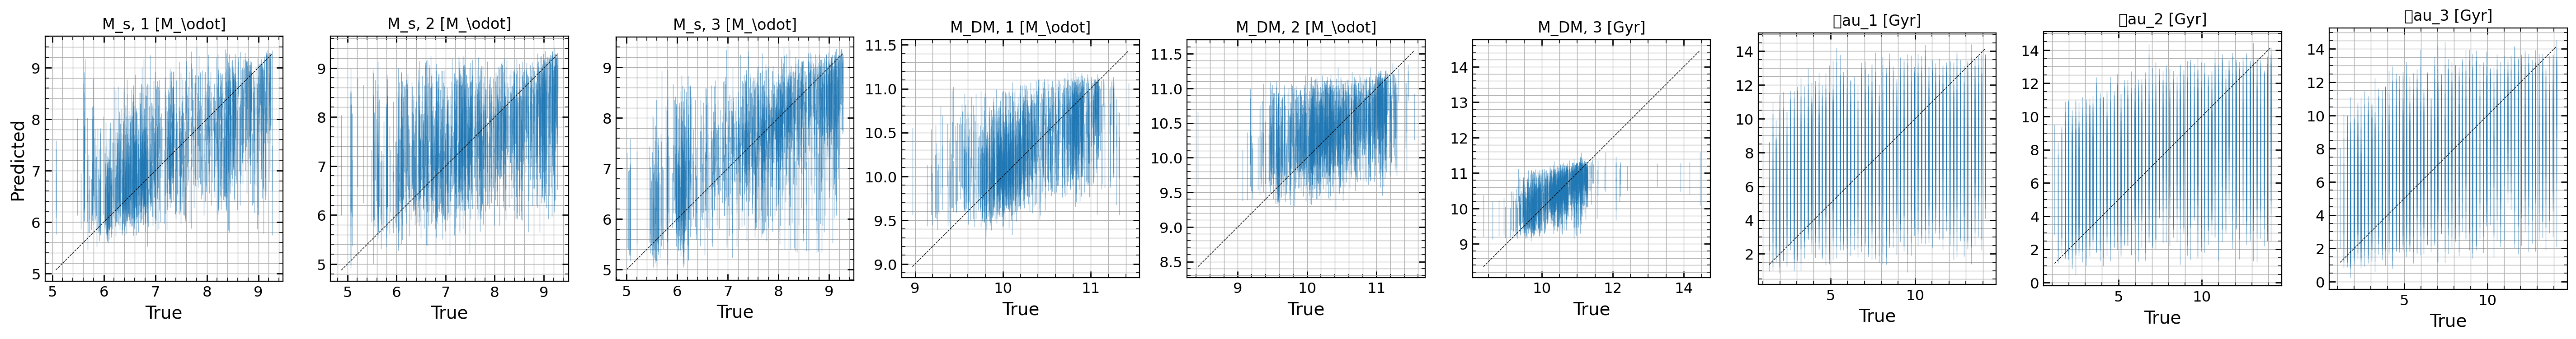

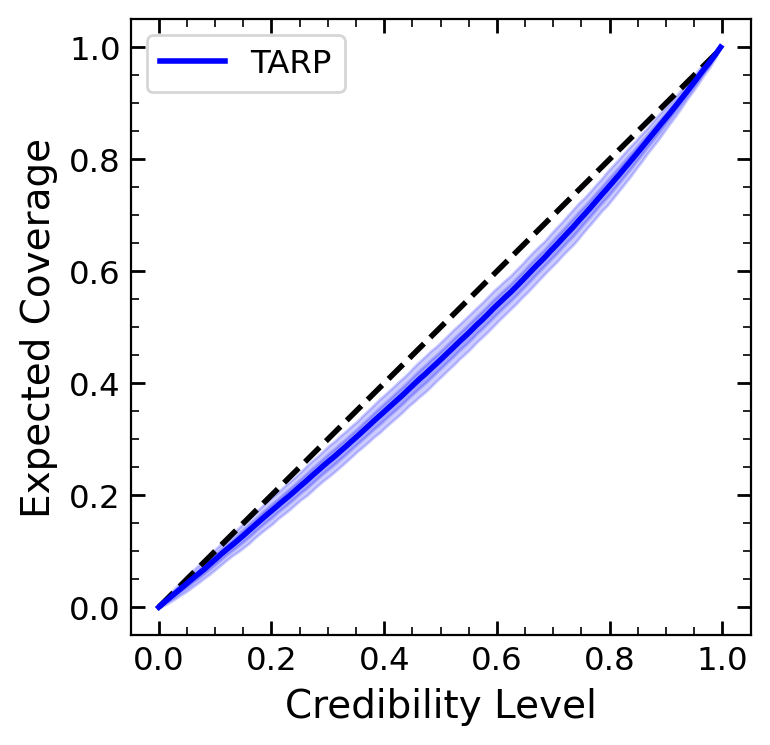

In [6]:
labels = ['M_s, 1 [M_\odot]', 'M_s, 2 [M_\odot]', 'M_s, 3 [M_\odot]', 'M_DM, 1 [M_\odot]', 'M_DM, 2 [M_\odot]', 'M_DM, 3 [Gyr]', '\tau_1 [Gyr]', '\tau_2 [Gyr]', '\tau_3 [Gyr]']
metric = PosteriorCoverage(
    num_samples=5000, sample_method='direct',
    labels=labels, plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=samples[m],
    x=torch.from_numpy(np.load('./x_test.npy')), theta=torch.from_numpy(np.load('./theta_test.npy'))
)
fig[3].savefig('coverage_2subhalos.png')

In [7]:
samples[m].__dict__

{'posteriors': [DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>,
  DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>,
  DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>,
  DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>],
 'num_components': 4,
 '_weights': tensor([0.0490, 0.0654, 0.4376, 0.4479], device='cuda:0'),
 'theta_transform': Inverse(IndependentTransform(ComposeTransform(
     SigmoidTransform(),
     AffineTransform()
 ), 1)),
 'prior': IndependentUniform(Uniform(low: torch.Size([9]), high: torch.Size([9])), 1),
 '_device': 'cuda:0',
 'potential_fn': <sbi.utils.posterior_ensemble.EnsemblePotential at 0x7ff65ab2d7e0>,
 '_map': None,
 '_purpose': '',
 '_x_shape': torch.Size([1, 1, 64, 64]),
 '_x': None,
 'name': 'toy_NPE_',
 'signatures': ['m1', 'm2', 'm3', 'm4']}

In [8]:
methods = [method_name for method_name in dir(samples[m]) if callable(getattr(samples[m], method_name))]

In [9]:
methods

['__class__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_calculate_map',
 '_x_else_default_x',
 'ensure_same_device',
 'log_prob',
 'map',
 'potential',
 'potential_fn',
 'sample',
 'set_default_x',
 'theta_transform']

In [10]:
samples[m].set_default_x(torch.from_numpy(np.load('./x_0.npy')).to('cuda') )
samples[m].log_prob(torch.from_numpy(np.load('./theta_0.npy')).float().to('cuda'))

tensor([-1.1661], device='cuda:0')

In [11]:
 all_loader = StaticNumpyLoader.from_config("./data.yaml")

In [12]:
methods = [method_name for method_name in dir(all_loader) if callable(getattr(all_loader, method_name))]

In [13]:
methods

['__class__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'from_config',
 'get_all_data',
 'get_all_parameters',
 'get_fid_parameters',
 'get_obs_data']